In [11]:
import tensorflow as tf
import cPickle
import os
import matplotlib.pyplot as plt
import numpy as np
import glob
import time
%matplotlib inline

In [2]:
file_path = os.path.expanduser('~/data/cifar10/cifar-10-batches-py/data_batch_1')

def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict
    
data_01 = unpickle(file = file_path)
data_01.keys()

['data', 'labels', 'batch_label', 'filenames']

In [17]:
train_files = glob.glob('/home/ubuntu/data/cifar10/cifar-10-batches-py/data_batch_*')
test_files = glob.glob('/home/ubuntu/data/cifar10/cifar-10-batches-py/test_batch')

images_ = []
labels_ = []
for i in train_files:
    images_.append(unpickle(file = i)['data'])
    labels_.append(np.array(unpickle(file = i)['labels']))


imgs_ = np.concatenate(images_)
labels_ = np.concatenate(labels_)
print "Train data set shape ", imgs_.shape, labels_.shape

images_test = []
labels_test = []
for i in test_files:
    images_test.append(unpickle(file = i)['data'])
    labels_test.append(np.array(unpickle(file = i)['labels']))
    
#print "Lables data set shape ", images_test.shape, labels_test.shape

Train data set shape  (50000, 3072) (50000,)


In [3]:
batch_size = 10
image_size = 32
channels = 3
NUM_CLASSES = 10

X = tf.placeholder(shape=[batch_size, image_size * image_size * channels], dtype=tf.float32)    
X_reshape = tf.reshape(X, shape=[batch_size, channels, image_size, image_size])
X_trans = tf.transpose(X_reshape, perm=[0,2,3,1])
X_formatted = tf.div(X_trans, 255.)
labels = tf.placeholder(shape=[batch_size], dtype=tf.int32)

def _variable_on_cpu(name, shape, initializer):
    with tf.device('/cpu:0'):
        dtype = tf.float32
        var = tf.get_variable(name, shape, initializer=initializer, dtype=tf.float32)
    return var
    
def _variable_on_gpu(name, shape, initializer):
    with tf.device('/gpu:0'):
        dtype = tf.float32
        var = tf.get_variable(name, shape, initializer=initializer, dtype=tf.float32)
    return var

def _variable_with_weight_decay(name, shape, stddev, wd):
    dtype = tf.float32
    var = _variable_on_cpu(name,shape,tf.truncated_normal_initializer(stddev=stddev, dtype=dtype))
    if wd is not None:
        weight_decay = tf.multiply(tf.nn.l2_loss(var), wd, name='weight_loss')
        tf.add_to_collection('losses', weight_decay)
    return var

In [4]:
# --------------------------------------------------
kernel = _variable_with_weight_decay(name='kernel_one', shape=[5, 5, 3, 64], stddev=5e-2, wd=0.0)
conv = tf.nn.conv2d(X_formatted, kernel, [1, 1, 1, 1], padding='SAME')
biases = _variable_on_gpu('biases', [64], tf.constant_initializer(0.0))
pre_activation = tf.nn.bias_add(conv, biases)
conv1 = tf.nn.relu(pre_activation, name='conv_one')
# pool1
pool1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool1')
# norm1
norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,name='norm1')

In [5]:
# --------------------------------------------------
kernel2 = _variable_with_weight_decay('weights2', shape=[5, 5, 64, 64], stddev=5e-2, wd=0.0)
conv2 = tf.nn.conv2d(norm1, kernel2, [1, 1, 1, 1], padding='SAME')
biases2 = _variable_on_gpu('biases2', [64], tf.constant_initializer(0.1))
pre_activation2 = tf.nn.bias_add(conv2, biases2)
conv_2 = tf.nn.relu(pre_activation2)
# norm2
norm2 = tf.nn.lrn(conv_2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,name='norm2')
# pool2
pool2 = tf.nn.max_pool(norm2, ksize=[1, 3, 3, 1],strides=[1, 2, 2, 1], padding='SAME', name='pool2')

In [6]:
# --------------------------------------------------
reshape = tf.reshape(pool2, [batch_size, -1])
dim = reshape.get_shape()[1].value
weights3 = _variable_with_weight_decay('weights3', shape=[dim, 384],stddev=0.04, wd=0.004)
biases3 = _variable_on_gpu('biases3', [384], tf.constant_initializer(0.1))
local3 = tf.nn.relu(tf.matmul(reshape, weights3) + biases3, name='local2')

In [7]:
# --------------------------------------------------
weights4 = _variable_with_weight_decay('weights4', shape=[384, 192],stddev=0.04, wd=0.004)
biases4 = _variable_on_gpu('biases4', [192], tf.constant_initializer(0.1))
local4 = tf.nn.relu(tf.matmul(local3, weights4) + biases4, name='local4')

In [8]:
# --------------------------------------------------
weights5 = _variable_with_weight_decay('weights5', [192, NUM_CLASSES],stddev=1/192.0, wd=0.0)
biases5 = _variable_on_gpu('biases5', [NUM_CLASSES], tf.constant_initializer(0.0))
softmax_linear = tf.add(tf.matmul(local4, weights5), biases5, name='local5')

In [9]:
labels = tf.cast(labels, dtype=tf.int64)
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(softmax_linear, labels))
optim = tf.train.GradientDescentOptimizer(learning_rate=0.05).minimize(loss)

In [5]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [7]:
rows = np.random.choice(np.arange(10000), size=10)
dict_ims = {X:data_01['data'][rows, :], labels:np.array(data_01['labels'])[rows]}

Train Model

In [39]:
sess.close()

In [40]:
loss_ = []
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [45]:
# model save 
saver = tf.train.Saver()
save_path = '/home/ubuntu/tf_models/cifar10/cifar_model.ckpt'
# output to tensorboard
summary_op=tf.summary.scalar('Loss', loss)
#writer = tf.summary.FileWriter('./cifar10', graph=tf.get_default_graph())
writer = tf.summary.FileWriter('/home/ubuntu/tf_board/cifar10/', graph=sess.graph)

### Test Model on small batch size to see if data flows through model

In [41]:
# rows = np.random.choice(np.arange(10000), size=10)
# dict_ims = {X:data_01['data'][rows, :], labels:np.array(data_01['labels'])[rows]}

In [42]:
# #test run on one train data set (out of 5)
# ptime = time.time()
# for i in range(5000):
#     _, l = sess.run([optim, loss], feed_dict=dict_ims)
# #     if i % 10 == 0:
# #         print l
# print "Elapsed time ", time.time() - ptime

In [46]:
for i in range(100001):
    rows = np.random.choice(np.arange(50000), size=10)
    dict_ims = {X:imgs_[rows, :], labels:labels_[rows]}
    _, l = sess.run([optim, loss] , feed_dict=dict_ims)
    if i % 100 == 0:
        loss_.append(l)        
        writer.add_summary(sess.run(summary_op, feed_dict=dict_ims), global_step=i)
    if i % 1000 == 0:
        pred, labs = sess.run([tf.arg_max(tf.nn.softmax(softmax_linear), dimension=1), labels] , feed_dict=dict_ims)
        print "Accuracy Mini Batch %f" %(sum(pred == labs) / 10.)
        print i
    if i % 5000 == 0:
        saver.save(sess, save_path=save_path, global_step=i)

Accuracy 0.200000
0
Accuracy 0.600000
1000
Accuracy 0.800000
2000
Accuracy 0.900000
3000
Accuracy 0.700000
4000
Accuracy 1.000000
5000
Accuracy 0.800000
6000
Accuracy 0.900000
7000
Accuracy 0.900000
8000
Accuracy 0.900000
9000
Accuracy 1.000000
10000
Accuracy 1.000000
11000
Accuracy 1.000000
12000
Accuracy 1.000000
13000
Accuracy 1.000000
14000
Accuracy 1.000000
15000
Accuracy 1.000000
16000
Accuracy 1.000000
17000
Accuracy 1.000000
18000
Accuracy 0.900000
19000
Accuracy 1.000000
20000
Accuracy 1.000000
21000
Accuracy 1.000000
22000
Accuracy 1.000000
23000
Accuracy 1.000000
24000
Accuracy 1.000000
25000
Accuracy 1.000000
26000
Accuracy 1.000000
27000
Accuracy 1.000000
28000
Accuracy 1.000000
29000
Accuracy 1.000000
30000
Accuracy 1.000000
31000
Accuracy 1.000000
32000
Accuracy 1.000000
33000
Accuracy 1.000000
34000
Accuracy 0.900000
35000
Accuracy 1.000000
36000
Accuracy 1.000000
37000
Accuracy 1.000000
38000
Accuracy 0.900000
39000
Accuracy 1.000000
40000
Accuracy 1.000000
41000
Accur

In [52]:
import pandas as pd

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  app.launch_new_instance()


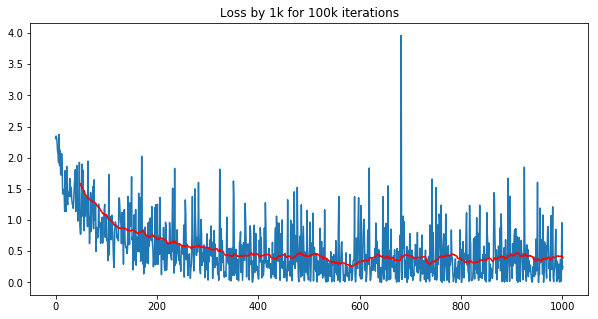

In [57]:
plt.figure(figsize=(10,5))
plt.plot(loss_)
plt.plot(pd.rolling_mean(np.array(loss_), window=50), 'red')
plt.title("Loss by 1k for 100k iterations")

### Validation Errors

In [74]:
images_test = np.array(images_test).reshape(10000, 3072)
labels_test = np.array(labels_test).reshape(10000,)

In [83]:
accuracy = []
for i in range(1000):
    rows = np.random.choice(np.arange(10000), size=10)
    dict_ims = {X:images_test[rows, :], labels:labels_test[rows]}
    pred, labs = sess.run([tf.arg_max(tf.nn.softmax(softmax_linear), dimension=1), labels] , feed_dict=dict_ims)
    accuracy.append(sum(pred == labs) / 10.)

0.6773


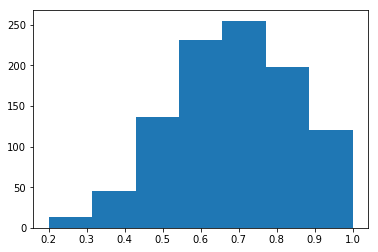

In [88]:
plt.hist(accuracy, bins=7)
print np.array(accuracy).mean()